In [4]:
import sys
sys.path.append("..")
from crowd_sim.envs.utils.action import ActionRot
from env_setup import *
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from math import pi
import torch
from torch.nn import Sequential, Linear, ReLU, Module
from tqdm import tqdm_notebook
from torch.optim import Adam
import math 
import random
from torch.nn.functional import mse_loss
import torch.nn.functional as F
import itertools
from torch.distributions import Categorical
from multiprocessing_env import SubprocVecEnv
import time

In [5]:
class Reward_counter() :
    def __init__(self, n_workers) :
        self.n_workers = n_workers
        self.reset()
        
    def reset(self) :
        self.reward_log = [[] for i in range(self.n_workers)]
        self.acc_reward = np.zeros(self.n_workers)
        self.acc_dones = np.zeros(self.n_workers)
        
    def update(self, rewards, dones) :
        for i, (r, done) in enumerate(zip(rewards, dones)) :
            self.update_worker(i, r, done)
            
    def update_worker(self, i, reward, done) :
        self.acc_reward[i] += reward
        if done : 
            self.reward_log[i].append(self.acc_reward[i])
            self.acc_reward[i] = 0
            self.acc_dones[i] += 1
        
    def plot_results(self, conv=100) :
        plt.title('Reward avg per workers over episodes')
        plt.xlabel('Episode')
        plt.ylabel('Reward avg')
        for i in range(self.n_workers) :
            rew_worker = rewards_avg = np.convolve(self.reward_log[i], np.ones((conv,))/conv, mode='valid')
            plt.plot(rew_worker, label=f'worker {i}')
        plt.show()
        for i in range(self.n_workers) :
            print('Worker {} did {} full sims'.format(i, self.acc_dones[i]))

In [48]:
def batch_iter(advantage, ob_states, actions, log_probs, returns, n_steps, n_workers, n_humans, st_size, batch_size=4) :
    for i in range(n_steps // batch_size) :
        idxs = np.random.permutation(range(n_steps))[:batch_size]
        yield advantage[idxs].view(-1,1) , ob_states[idxs].view(-1, n_humans, st_size),  actions[idxs].view(-1, 1), log_probs[idxs].view(-1, 1) , returns[idxs].view(-1, 1), idxs

In [53]:
def ppo_train(actor_critic, enviorements, n_workers, n_episodes = 100, lr = 1e-3, 
              gamma = 0.99, n_steps = 16, eps = 0.25, batch_size = 4, n_epochs = 2,
              reward_counter=None, show_result=10, device='cpu', n_humans=5, st_size=14, print_time=False) :
    
    opt = Adam(actor_critic.model.parameters(), lr=lr)
    reward_counter = Reward_counter(n_workers) if reward_counter is None else reward_counter
    
    for i in tqdm_notebook(range(n_episodes)) :

        rewards = torch.zeros((n_steps, n_workers), dtype=torch.float).to(device)
        mask = torch.zeros((n_steps, n_workers), dtype=torch.float).to(device)
        log_probs = torch.zeros((n_steps, n_workers), dtype=torch.float).to(device)
        values = torch.zeros((n_steps, n_workers), dtype=torch.float).to(device)
        actions = torch.zeros((n_steps, n_workers), dtype=torch.float).to(device)
        ob_states = torch.zeros((n_steps, n_workers, n_humans, st_size), dtype=torch.float).to(device)


        if i == 0 :
            observations = enviorements.reset()

        step = 0
        if print_time :
            print('Starting episode {}'.format(i))
        time_start_ep = time.time() 
        while step < n_steps :

            vals, dist = actor_critic.predict(observations)
            
            ob_states[step] = torch.tensor(observations, dtype=torch.float32, device=device)
            values[step] = vals.view(-1)

            #choose action
            act = dist.sample()
            log_probs[step] = dist.log_prob(act)
            actions[step] = act
            
            angle = act * 2 * math.pi/30
            action = [ActionRot(1, angle[i]) for i in range(n_workers)]

            obs, r, dones, _ = enviorements.step(action)
            mask[step] = torch.tensor(1-dones).to(device)
            rewards[step] = torch.from_numpy(r)

            observations = obs

            reward_counter.update(r, dones)
            step+=1      
        time_end_simu = time.time()

        #discounted returns calculation (with bootstraping)
        returns = torch.zeros((n_steps, n_workers), dtype=torch.float).to(device)
        with torch.no_grad() :
            q_val, _= actor_critic.predict(observations)
        q_val = q_val.view(-1).detach()
        for i in reversed(range(n_steps)) :
            q_val = rewards[i] + gamma * q_val * (mask[i])
            returns[i] = q_val
        advantage = (returns - values).detach()
        
        time_start_opt = time.time()
        #optimization
        for epoch in range(n_epochs) :
            a = 0
            for adv_b, state_b, action_b, l_probs_b, returns_b, idxs in batch_iter(advantage, ob_states, actions, 
                                                                                   log_probs, returns.detach(), n_steps=n_steps, n_workers=n_workers, n_humans=n_humans,
                                                                                   st_size=st_size, batch_size=batch_size) :

                #vals, dist = actor_critic.predict(state_b.view(-1, n_humans, st_size).numpy())
                vals, dist = actor_critic.predict(state_b.numpy())
                
                new_actor_probs = dist.log_prob(action_b)
                
                entropy = dist.entropy().mean()
                
                #probability ration and clipped prob ration
                r = torch.exp((new_actor_probs) - (l_probs_b.detach()))
                clipped_r = torch.clamp(r, 1-eps, 1+eps)
                adv = returns_b.view(batch_size, n_workers, -1) - vals.view(batch_size, n_workers, 1)

                #critic loss
                critic_loss = adv.pow(2).mean()

                #actor loss
                clipped_loss = clipped_r * adv_b.detach()
                loss_ = r * adv_b.detach()
                actor_loss = -torch.min(clipped_loss, loss_).mean()

                opt.zero_grad()
                loss = 0.5 * (critic_loss + actor_loss) 
                loss.backward()
                opt.step()
        
        time_end_ep = time.time()
        time_epiode = time_end_ep - time_start_ep
        time_opti = time_end_ep - time_start_opt
        time_simu = time_end_simu - time_start_ep
        
        if print_time :
            print('Episode {} took {:.2f}s, {:.2f}s simu, {:.2f}s opti'.format(i, time_epiode, time_simu, time_opti))
        
    if show_result is not None :
        reward_counter.plot_results(conv=show_result)
        
    return actor_critic, reward_counter
    
    

In [54]:
ac_policy = gen_policy_discrete()
envs = gen_multi_envs(4, ac_policy)

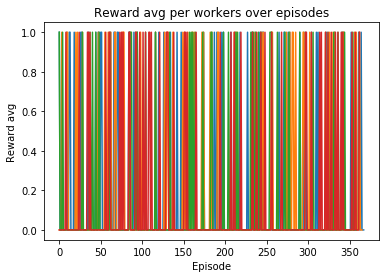

Worker 0 did 368.0 full sims
Worker 1 did 366.0 full sims
Worker 2 did 359.0 full sims
Worker 3 did 363.0 full sims


In [60]:
ac_policy, rc = ppo_train(ac_policy, envs, 4, n_episodes=2000 , show_result=1)

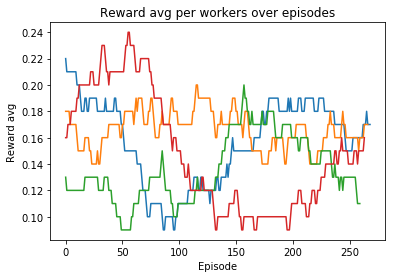

Worker 0 did 368.0 full sims
Worker 1 did 366.0 full sims
Worker 2 did 359.0 full sims
Worker 3 did 363.0 full sims


In [61]:
rc.plot_results(conv=100)

In [38]:
%debug

> /home/louis/anaconda3/envs/zarr/lib/python3.7/site-packages/torch/functional.py(62)broadcast_tensors()
     60                 [0, 1, 2]])
     61     """
---> 62     return torch._C._VariableFunctions.broadcast_tensors(tensors)
     63 
     64 

ipdb> UP
*** NameError: name 'UP' is not defined
ipdb> UP
*** NameError: name 'UP' is not defined
ipdb> up
> /home/louis/anaconda3/envs/zarr/lib/python3.7/site-packages/torch/distributions/categorical.py(117)log_prob()
    115             self._validate_sample(value)
    116         value = value.long().unsqueeze(-1)
--> 117         value, log_pmf = torch.broadcast_tensors(value, self.logits)
    118         value = value[..., :1]
    119         return log_pmf.gather(-1, value).squeeze(-1)

ipdb> up
> <ipython-input-34-a1e587e98c8e>(69)ppo_train()
     67                 vals, dist = actor_critic.predict(state_b.view(-1, n_humans, st_size).numpy())
     68 
---> 69                 new_actor_probs = dist.log_prob(action_b)
     70 
     71 

In [39]:
a = torch.nn.Linear(4, 2)

In [47]:
x = torch.randn(5, 4)

In [46]:
a(x)

tensor([[[-2.6484e-01,  5.5036e-01],
         [-4.2371e-02,  1.3881e-01],
         [ 7.0237e-05,  1.1711e-01],
         [-2.4346e-01,  1.0423e-01],
         [-3.1349e-01,  8.4003e-01]],

        [[-2.6750e-01,  6.9114e-01],
         [-9.1891e-03,  2.3918e-02],
         [-2.5294e-01,  5.9097e-01],
         [-4.7895e-01,  1.3668e+00],
         [-1.3171e-02,  5.2474e-01]],

        [[ 1.2104e-01, -6.7630e-01],
         [-2.8860e-01,  9.3269e-01],
         [ 3.2791e-01, -3.8415e-01],
         [-1.3280e-01,  1.4853e-01],
         [-2.1250e-01,  5.5291e-01]],

        [[-5.1835e-02,  8.8525e-01],
         [-1.7309e-01,  4.3186e-02],
         [ 3.5433e-01, -8.1039e-01],
         [ 1.5923e-01,  4.2869e-01],
         [-2.1285e-01, -1.2054e-01]],

        [[-2.5951e-01,  7.5559e-01],
         [ 9.8576e-02, -7.6201e-01],
         [-7.5029e-02,  5.4759e-01],
         [ 1.0404e-01, -1.3229e-01],
         [ 9.3082e-03,  2.3355e-01]],

        [[-4.7663e-02,  1.1104e-02],
         [-5.0504e-01,  5.69

In [16]:
ac_policy.predict(x)

(tensor([[-0.0208],
         [-0.0564],
         [ 0.0120],
         [-0.0282],
         [ 0.0148],
         [-0.0257],
         [-0.0547],
         [-0.0626],
         [-0.0515],
         [-0.0968]], grad_fn=<AddmmBackward>),
 Normal(loc: torch.Size([10]), scale: torch.Size([10])),
 Normal(loc: torch.Size([10]), scale: torch.Size([10])))

In [17]:
ac_policy.model.dist_mean

tensor([[-1.7986, -2.2951],
        [-1.7868, -2.3035],
        [-1.7848, -2.3046],
        [-1.8176, -2.3641],
        [-1.7871, -2.2997],
        [-1.8295, -2.3181],
        [-1.7942, -2.3437],
        [-1.7889, -2.2888],
        [-1.7894, -2.3200],
        [-1.8028, -2.3087]], grad_fn=<SliceBackward>)

In [7]:
%debug

> /home/louis/anaconda3/envs/zarr/lib/python3.7/site-packages/numpy/core/numeric.py(1112)convolve()
   1110         raise ValueError('a cannot be empty')
   1111     if len(v) == 0:
-> 1112         raise ValueError('v cannot be empty')
   1113     mode = _mode_from_name(mode)
   1114     return multiarray.correlate(a, v[::-1], mode)

ipdb> a
a = array([0.5, 0.5])
v = array([], dtype=float64)
mode = 'valid'
ipdb> type(a=
*** SyntaxError: unexpected EOF while parsing
ipdb> type(a)
<class 'numpy.ndarray'>
ipdb> print(a)
[0.5 0.5]
ipdb> a
a = array([0.5, 0.5])
v = array([], dtype=float64)
mode = 'valid'
ipdb> v
array([], dtype=float64)
ipdb> up
> <ipython-input-2-e5dcaac85896>(27)plot_results()
     25         plt.ylabel('Reward avg')
     26         for i in range(self.n_workers) :
---> 27             rew_worker = rewards_avg = np.convolve(self.reward_log[i], np.ones((conv,))/conv, mode='valid')
     28             plt.plot(rew_worker, label=f'worker {i}')
     29         plt.show()

ipdb

In [89]:
a = torch.randn(1, 10)
a.requires_grad  = True

In [90]:
b = clipped_exp.apply(a)

In [91]:
c = b.mean()

In [92]:
c.backward()

In [93]:
a.grad

tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000]])

In [95]:
b.grad

In [1]:
import sys
sys.path.append("..")
from crowd_sim.envs.utils.action import ActionRot
from env_setup import *
from crowd_sim_ppo import *
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from math import pi
import torch
from torch.nn import Sequential, Linear, ReLU, Module
from tqdm import tqdm_notebook
from torch.optim import Adam
import math 
import random
from torch.nn.functional import mse_loss
import torch.nn.functional as F
import itertools
from torch.distributions import Categorical
from multiprocessing_env import SubprocVecEnv
import time

In [2]:
ac_policy = gen_policy()
env = gen_env(ac_policy)
ob = env.reset()

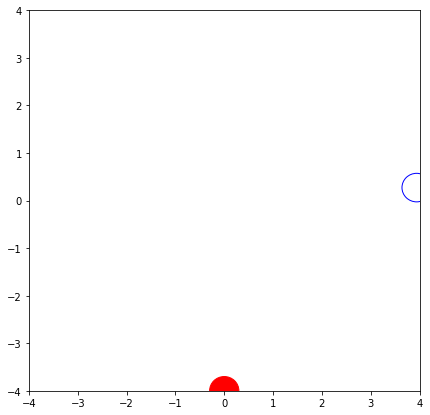

In [3]:
env.render()

In [4]:
env.humans

In [5]:
x,y = ac_policy.predict(np.asarray([ob]))

In [6]:
x

(tensor([[0.0142]], grad_fn=<AddmmBackward>),
 Normal(loc: tensor([-0.0063], grad_fn=<SelectBackward>), scale: tensor([1.0192], grad_fn=<SelectBackward>)),
 Normal(loc: tensor([0.1188], grad_fn=<SelectBackward>), scale: tensor([1.0146], grad_fn=<SelectBackward>)))

In [7]:
y

tensor([[[ 2.0000,  1.0000,  0.0000,  0.3000,  0.0000,  0.0000,  4.2722,
          -3.9402,  0.0000,  0.0000,  0.3000,  5.8117,  0.6000]]])

In [8]:
env.humans[1].py

-4.0

In [22]:
d = Categorical(torch.tensor([1.0,2.9, 3.0]))

In [32]:
d.log_prob(torch.tensor([[1, 1], [2, 1]]))

tensor([[-0.8668, -0.8668],
        [-0.8329, -0.8668]])

In [62]:

torch.exp(1)

TypeError: exp(): argument 'input' (position 1) must be Tensor, not int